# Experiments with Hough transform

Conventional Hough transform operates in so-called $(r, \theta)$ parameter space where each line is represented with an equation of a form

$$x \cos \theta + y \sin \theta = r.$$

However, to easily distinguish between horizontal and vertical lines, especially in the problem of vanishing points identification, it is reasonable to utilise the Hough transform that operates in $(k, b)$ parameter space also known as "slope-intercept" parameters:

$$y = kx + b.$$

In [1]:
# Necessary includes

# Scikit-image (for image storing)
from skimage import io
from skimage import color
from skimage import filters
from skimage import draw
from skimage import measure
# NumPy (for fast vectorised computations)
import numpy as np
# Matplotlib (for inline image rendering)
import matplotlib.pyplot as plot

In [2]:
# Experimental placeholder IM_PATH
#
# Needs to be replaced with a varibale set by end user
# in production version of the program

IM_PATH = '../sample_images/Moscow.jpg'

## Auxiliary toolset

In [3]:
def render_image(image, grayscale=False):
    plot.figure(figsize=(10, 10))
    if grayscale:
        plot.imshow(image, cmap=plot.cm.gray)
    else:
        plot.imshow(image)
    return

## Step 1. Image load

We'll utilise Scikit-image because:

* it has lots of easy-to-use tools;
* it is directly compatible with NumPy.

In [4]:
image = io.imread(IM_PATH)

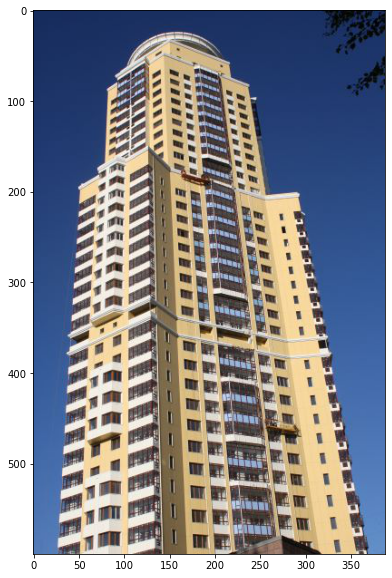

In [5]:
render_image(image)

## Step 2. Edge detection

With $3 \times 3$ Scharr operator.

In [6]:
edges = filters.scharr(filters.gaussian(color.rgb2gray(image), sigma=1))
edges[np.where(edges > filters.threshold_otsu(edges))] = 1
edges[np.where(edges != 1)] = 0
edges = edges.astype('int')

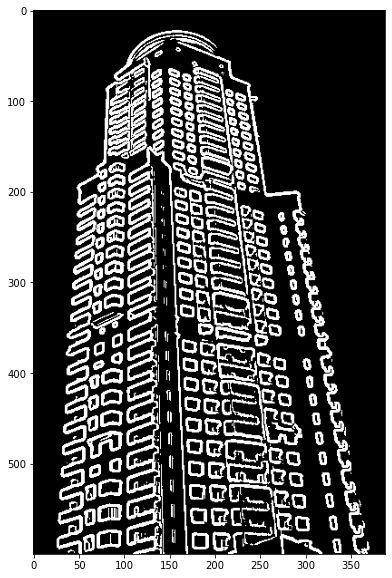

In [7]:
render_image(edges, grayscale=True)

## Step 3. Apply Hough

Hough transform is aimed at straight line detection. As it was said before, we represent lines in their slope-intercept parametrisation:

* $k$ is a slope;
* $b$ is an intercept.

In order to avoid infinitely large values of $k$ we distinguish between **predominantly vertical** and **predominantly horizontal** lines. Thus, the absolute values of $k$ never exceed one.

Mind the unusual coordinate system that is used here in images: the $x$ axis goes from the top left corner down to the bottom left corner; the $y$ axis goes from the top left corner to the top right corner. Hence, **predominantly horizontal** lines are expressed as

$$x = ky + b$$

and **predominantly vertical**, respectively, are represented as

$$y = kx + b.$$

In [8]:
def hough_kb(image):
    """
    Hough transform in (k, b) parameter space
    
    Parameters
    ==========
    image : NumPy (N x M) array
            Unichomic (single-channel) image (width = M, height = N).
    
    Return
    ======
    hough_h : NumPy ((2M + 1) x (N + 2M)) array
              Hough space of predominantly horizontal lines.
              Axis 0 represents values of k that change uniformly from -1 to 1.
              Axis 1 represents values of b that change uniformly from -M to N + M.
    hough_v : NumPy ((2N + 1) x (2N + M)) array
              Hough space of predominantly horizontal lines.
              Axis 0 represents values of k that change uniformly from -1 to 1.
              Axis 1 represents values of b that change uniformly from -N to N + M.
    """
    # 1. Initialise horizontal Hough space
    hough_h = np.zeros((2 * image.shape[1] + 1, image.shape[0] + 2 * image.shape[1]), dtype='int')
    k_h = np.arange(hough_h.shape[0])
    k_true_h = np.linspace(-1.0, 1.0, hough_h.shape[0])
    # 2. Initialise vertical Hough space
    hough_v = np.zeros((2 * image.shape[0] + 1, 2 * image.shape[0] + image.shape[1]), dtype='int')
    k_v = np.arange(hough_v.shape[0])
    k_true_v = np.linspace(-1.0, 1.0, hough_v.shape[0])
    # 3. Saturate Hough spaces
    for point in np.array(np.where(image != 0)).T:
        b = (point[0] - k_true_h * point[1] + image.shape[1]).astype('int')
        hough_h[k_h, b] += image[point[0]][point[1]]
        b = (point[1] - k_true_v * point[0] + image.shape[0]).astype('int')
        hough_v[k_v, b] += image[point[0]][point[1]]
    return hough_h, hough_v

In [9]:
hough_h, hough_v = hough_kb(edges)

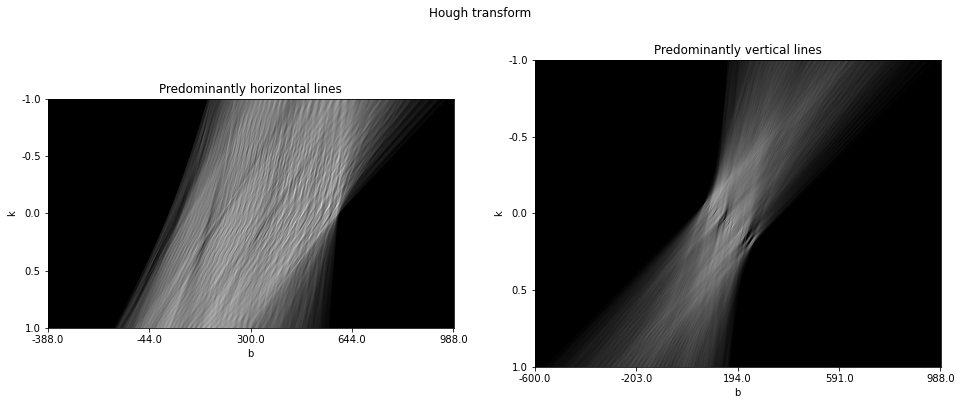

In [10]:
plot.figure(figsize=(16, 6))
plot.suptitle('Hough transform')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-image.shape[1], image.shape[0] + image.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(hough_h / np.max(hough_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-image.shape[0], image.shape[0] + image.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(hough_v / np.max(hough_v), cmap=plot.cm.gray);

## Step 4. Threshold Hough

We look for significant bundles in the Hough space.

In [11]:
def hough_kb_peaks(hough_space, softness=1.6):
    """
    Identification of bundles in Hough space
    
    Nullifies all values that are less than max - s * std.
    
    Parameters
    ==========
    hough_space : NumPy (N x M) array
                  A Hough space.
    softness    : float (default value = 1.6)
                  Shows how strict the algorithm should be when
                  choosing the bundles. The greater the value, the
                  less strict the selection is. Corresponds to
                  coefficient s from the formula above. Values that
                  are less than or equal to 0 lead to a completely
                  blank result.
    
    Returns
    =======
    hough_peaks : NumPy (N x M) array
                  A thresholded Hough space.
    """
    # 1. We don't want to spoil the original Hough space
    hough_copy = hough_space.copy()
    # 2. Get rid of non-peak values
    softness = 1.5
    while hough_copy[hough_copy == 0].size / hough_copy.size < 0.9999:
        softness -= 0.1
        hough_copy[hough_space < np.max(hough_space) - softness * np.std(hough_space)] = 0
        print(f'Softness: {softness}, blank share: {hough_copy[hough_copy == 0].size / hough_copy.size}')
    while hough_copy[hough_copy == 0].size / hough_copy.size > 0.99999:
        softness += 0.01
        hough_copy[hough_space >= np.max(hough_space) - softness * np.std(hough_space)] = hough_space[hough_space >= np.max(hough_space) - softness * np.std(hough_space)]
        print(f'Softness: {softness}, blank share: {hough_copy[hough_copy == 0].size / hough_copy.size}')
    return hough_copy

In [12]:
peaks_h = hough_kb_peaks(hough_h)
peaks_v = hough_kb_peaks(hough_v)

Softness: 1.4, blank share: 0.9812468199096106
Softness: 1.2999999999999998, blank share: 0.9896095223130107
Softness: 1.1999999999999997, blank share: 0.9934714614947173
Softness: 1.0999999999999996, blank share: 0.996355990542037
Softness: 0.9999999999999997, blank share: 0.9977430711442339
Softness: 0.8999999999999997, blank share: 0.9987943716141391
Softness: 0.7999999999999997, blank share: 0.9992676438897369
Softness: 0.6999999999999997, blank share: 0.9996342896052198
Softness: 0.5999999999999998, blank share: 0.9997942294453922
Softness: 0.4999999999999998, blank share: 0.9998971147226962
Softness: 0.3999999999999998, blank share: 0.9999420101164287
Softness: 1.4, blank share: 0.9999690644026703


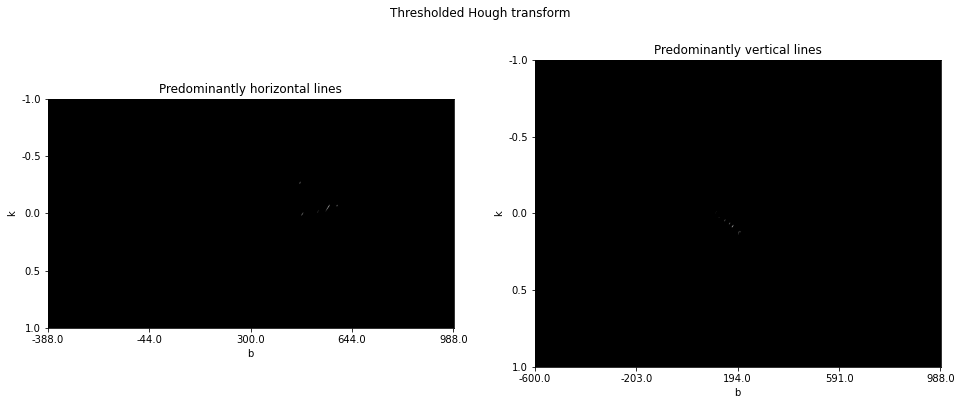

In [13]:
plot.figure(figsize=(16, 6))
plot.suptitle('Thresholded Hough transform')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-image.shape[1], image.shape[0] + image.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(peaks_h / np.max(peaks_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-image.shape[0], image.shape[0] + image.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(peaks_v / np.max(peaks_v), cmap=plot.cm.gray);

## Step 5. Identify clusters in Hough spaces

In [14]:
def clusterise(image):
    """
    Replace bundles with single pixels
    
    Finds connected regions in binarised copy of image and replaces
    each region with a single pixel that has cumulative value of all
    pixels from the corresponding region and is located in a centre
    of a bounding box of the region.
    
    Parameters
    ==========
    image : NumPy (N x M) array
            Unichomic (single-channel) image (width = M, height = N).
    
    Return
    ======
    clusters : NumPy (N x M) array
               A copy of image with all clusters replaced with a single
               pixel.
    """
    answer = np.zeros(image.shape)
    # 1. Create binary mask of non-zero pixels
    image_bin = image.copy()
    image_bin[image_bin != 0] = 1
    # 2. Form a list of connected regions
    labels, labels_count = measure.label(image_bin, background=0, return_num=True)
    clusters = tuple(np.where(labels == label) for label in range(1, labels_count + 1))
    # 3. Replace each cluster with a single representative
    for cluster in clusters:
        cluster_centre = (np.mean(cluster[0]).astype('int'), np.mean(cluster[1]).astype('int'))
        answer[cluster_centre[0]][cluster_centre[1]] = np.sum(image[cluster])
    return answer.astype('int')

In [15]:
clusters_h = clusterise(peaks_h)
clusters_v = clusterise(peaks_v)

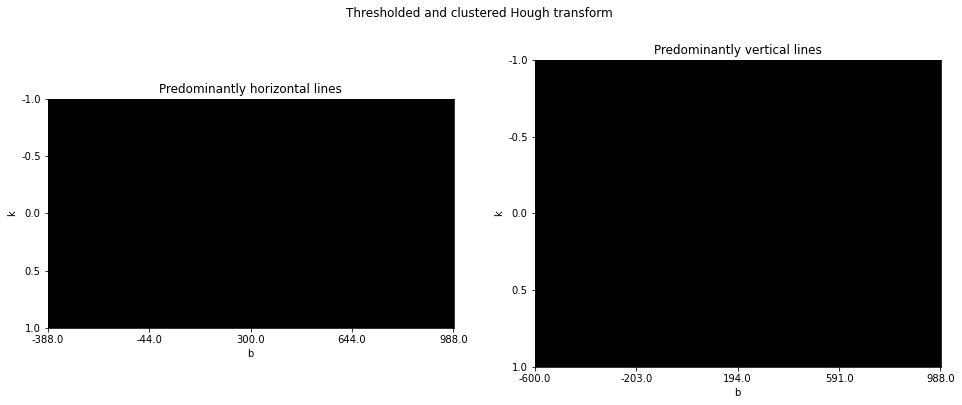

In [16]:
plot.figure(figsize=(16, 6))
plot.suptitle('Thresholded and clustered Hough transform')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, clusters_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-image.shape[1], image.shape[0] + image.shape[1], 5))
ax_h.set_yticks(np.linspace(0, clusters_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(clusters_h / np.max(clusters_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, clusters_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-image.shape[0], image.shape[0] + image.shape[1], 5))
ax_v.set_yticks(np.linspace(0, clusters_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(clusters_v / np.max(clusters_v), cmap=plot.cm.gray);

It may look like the pictures are blank but if we zoom in, we can actually discover some pixels.

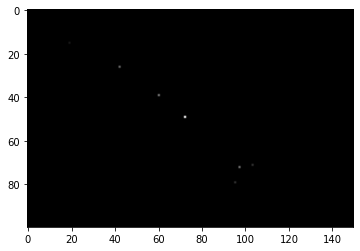

In [17]:
plot.imshow(clusters_v[600:700, 700:850] / np.max(clusters_v), cmap=plot.cm.gray);

## Step 5. Apply Hough for Hough

We consider Hough Hough spaces to discover vertical and horizontal vanishing points.

In [18]:
hough_h_hough_h, hough_h_hough_v = hough_kb(clusters_h)

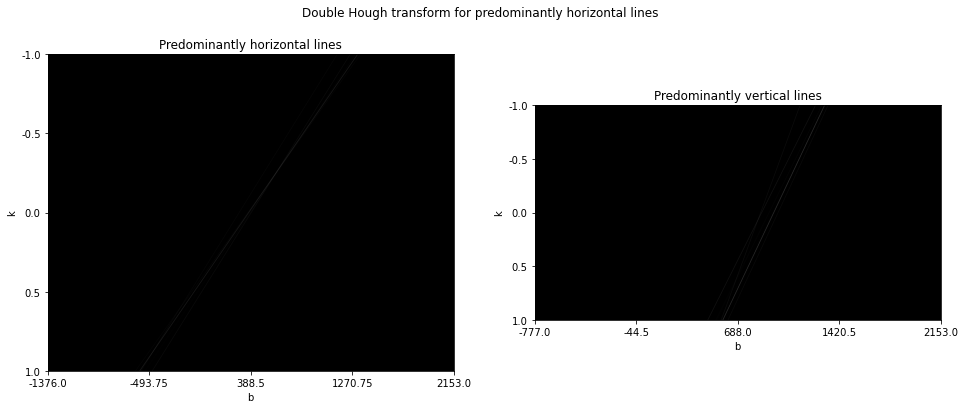

In [19]:
plot.figure(figsize=(16, 6))
plot.suptitle('Double Hough transform for predominantly horizontal lines')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_h_hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-hough_h.shape[1], hough_h.shape[0] + hough_h.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_h_hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(hough_h_hough_h / np.max(hough_h_hough_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_h_hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-hough_h.shape[0], hough_h.shape[0] + hough_h.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_h_hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(hough_h_hough_v / np.max(hough_h_hough_v), cmap=plot.cm.gray);

In [20]:
hough_v_hough_h, hough_v_hough_v = hough_kb(clusters_v)

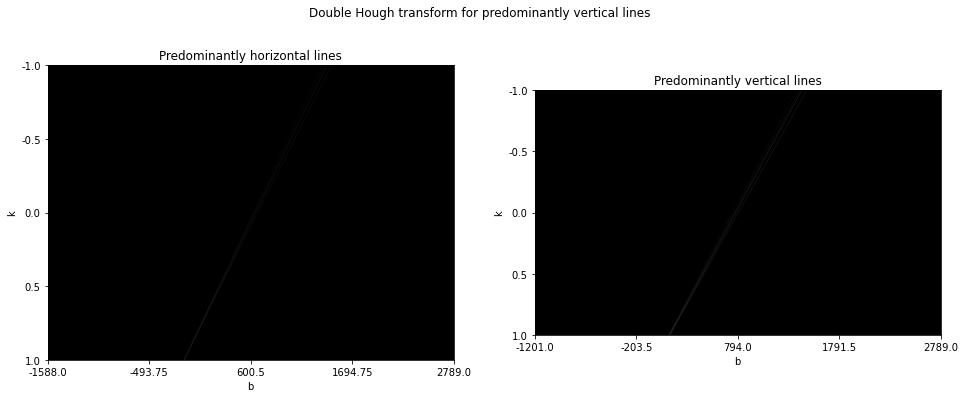

In [21]:
plot.figure(figsize=(16, 6))
plot.suptitle('Double Hough transform for predominantly vertical lines')

ax_h = plot.subplot(1, 2, 1)
ax_h.set_title('Predominantly horizontal lines')
ax_h.set_xticks(np.linspace(0, hough_v_hough_h.shape[1] - 1, 5))
ax_h.set_xticklabels(np.linspace(-hough_v.shape[1], hough_v.shape[0] + hough_v.shape[1], 5))
ax_h.set_yticks(np.linspace(0, hough_v_hough_h.shape[0] - 1, 5))
ax_h.set_yticklabels(np.linspace(-1, 1, 5))
ax_h.set_xlabel('b')
ax_h.set_ylabel('k')
ax_h.imshow(hough_v_hough_h / np.max(hough_v_hough_h), cmap=plot.cm.gray);

ax_v = plot.subplot(1, 2, 2)
ax_v.set_title('Predominantly vertical lines')
ax_v.set_xticks(np.linspace(0, hough_v_hough_v.shape[1] - 1, 5))
ax_v.set_xticklabels(np.linspace(-hough_v.shape[0], hough_v.shape[0] + hough_v.shape[1], 5))
ax_v.set_yticks(np.linspace(0, hough_v_hough_v.shape[0] - 1, 5))
ax_v.set_yticklabels(np.linspace(-1, 1, 5))
ax_v.set_xlabel('b')
ax_v.set_ylabel('k')
ax_v.imshow(hough_v_hough_v / np.max(hough_v_hough_v), cmap=plot.cm.gray);

## Step 6. Find out the coordinates of vanishing points

In [22]:
def get_vanishing_points(image, hough_h, hough_v, hough_h_hough_h, hough_h_hough_v, hough_v_hough_h, hough_v_hough_v):
    """
    Calculate coordinates of vanishing points
    
    Calculates coordinates of dominant horizontal and dominant vertical
    vanishing points using the original image, its Hough transform and
    double Hough transform applied to each of the original Hough spaces.
    
    Parameters
    ==========
    image           : NumPy (N x M x ...) array
                      Original image.
    hough_h         : NumPy ((2M + 1) x (N + 2M)) array
                      Hough space with predominantly horizontal lines
                      of the original image.
    hough_v         : NumPy ((2N + 1) x (2N + M)) array
                      Hough space with predominantly vertical lines
                      of the original image.
    hough_h_hough_h : NumPy ((2N + 4M + 1) x (2N + 6M + 1)) array
                      Hough space with predominantly horizontal lines
                      of hough_h.
    hough_h_hough_v : NumPy ((4M + 3) x (N + 6M + 2)) array
                      Hough space with predominantly vertical lines
                      of hough_h.
    hough_v_hough_h : NumPy ((4N + 2M + 1) x (6N + 2M + 1)) array
                      Hough space with predominantly horizontal lines
                      of hough_v.
    hough_v_hough_v : NumPy ((4N + 3) x (6N + M + 2)) array
                      Hough space with predominantly vertical lines
                      of hough_v.
    
    Return
    ======
    (x_h, y_h) : tuple of int
                 Coordinates (in image coordinate system) of dominant
                 horizontal vanishing point.
    (x_v, y_v) : tuple of int
                 Coordinates (in image coordinate system) of dominant
                 vertical vanishing point.
    """
    # 1. Horizontal vanishing point
    if (np.max(hough_h_hough_h) > np.max(hough_h_hough_v)):
        k_, b_ = np.unravel_index(np.argmax(hough_h_hough_h), hough_h_hough_h.shape)
        k_ = -1 + k_ * 2 / (hough_h_hough_h.shape[0] - 1)
        b_ = b_ - hough_h.shape[1]
        k0 = int(hough_h.shape[0] / 2) # k = 0
        k1 = hough_h.shape[0] - 1 # k = 1
        b0 = int((k0 - b_) / k_)
        b1 = int((k1 - b_) / k_)
        x_h = b0 - image.shape[1]
        y_h = x_h - b1 + image.shape[1]
    else:
        k_, b_ = np.unravel_index(np.argmax(hough_h_hough_v), hough_h_hough_v.shape)
        k_ = -1 + k_ * 2 / (hough_h_hough_v.shape[0] - 1)
        b_ = b_ - hough_h.shape[0]
        k0 = int(hough_h.shape[0] / 2) # k = 0
        k1 = hough_h.shape[0] - 1 # k = 1
        b0 = int(k_ * k0 + b_)
        b1 = int(k_ * k1 + b_)
        x_h = b0 - image.shape[1]
        y_h = x_h - b1 + image.shape[1]
    # 2. Vertical vanishing point
    if (np.max(hough_v_hough_h) > np.max(hough_v_hough_v)):
        k_, b_ = np.unravel_index(np.argmax(hough_v_hough_h), hough_v_hough_h.shape)
        k_ = -1 + k_ * 2 / (hough_v_hough_h.shape[0] - 1)
        b_ = b_ - hough_v.shape[1]
        k0 = int(hough_v.shape[0] / 2) # k = 0
        k1 = hough_v.shape[0] - 1 # k = 1
        b0 = int((k0 - b_) / k_)
        b1 = int((k1 - b_) / k_)
        y_v = b0 - image.shape[0]
        x_v = y_v - b1 + image.shape[0]
    else:
        k_, b_ = np.unravel_index(np.argmax(hough_v_hough_v), hough_v_hough_v.shape)
        k_ = -1 + k_ * 2 / (hough_v_hough_v.shape[0] - 1)
        b_ = b_ - hough_v.shape[0]
        k0 = int(hough_v.shape[0] / 2) # k = 0
        k1 = hough_v.shape[0] - 1 # k = 1
        b0 = int(k_ * k0 + b_)
        b1 = int(k_ * k1 + b_)
        y_v = b0 - image.shape[0]
        x_v = y_v - b1 + image.shape[0]
    return (x_h, y_h), (x_v, y_v)

In [23]:
v_h, v_v = get_vanishing_points(image, hough_h, hough_v, hough_h_hough_h, hough_h_hough_v, hough_v_hough_h, hough_v_hough_v)

In [24]:
print(f'Horizontal vanishing point : {v_h}')
print(f'Vertical vanishing point : {v_v}')

Horizontal vanishing point : (484, 1490)
Vertical vanishing point : (-676, 116)


Let us see how the vanishing points are identified inside the `get_vanishing_points` function.

Since any line in the Hough space is uniquely associated with the point in the image space, we find a line that goes through the bundles of the Hough spaces.

#### Line corresponding to horizontal vanishing point

In [25]:
np.max(hough_h_hough_h), np.max(hough_h_hough_v)

(7082, 5365)

In [26]:
np.unravel_index(np.argmax(hough_h_hough_h), hough_h_hough_h.shape)

(1018, 1991)

In [27]:
k = -1 + 1018 * 2 / (hough_h_hough_h.shape[0] - 1)
b = 1991 - peaks_h.shape[1]
k, b

(-0.2601744186046512, 615)

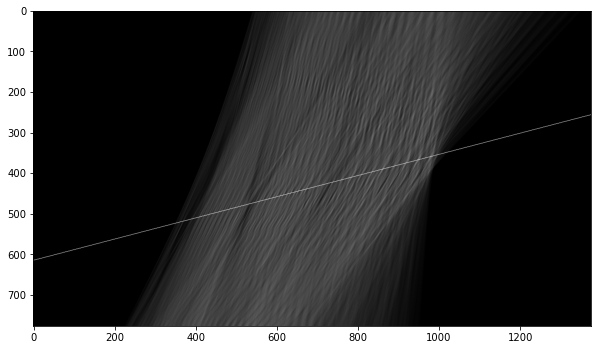

In [28]:
if IM_PATH == '../sample_images/Moscow.jpg':
    hough_h_ = hough_h.copy()

    c0 = 0
    c1 = hough_h_.shape[1] - 1
    r0 = int(k * c0 + b)
    r1 = int(k * c1 + b)
    rr, cc = draw.line(r0, c0, r1, c1)

    hough_h_[rr, cc] = 2 * np.max(hough_h_)

    render_image(hough_h_, grayscale=True)
else:
    print('This visualisation has been hardcoded for Moscow.jpg.')

#### Line corresponding to vertical vanishing point

In [29]:
np.max(hough_v_hough_h), np.max(hough_v_hough_v)

(15918, 9645)

In [30]:
np.unravel_index(np.argmax(hough_v_hough_h), hough_v_hough_h.shape)

(2999, 1551)

In [31]:
k = -1 + 2999 * 2 / (hough_v_hough_h.shape[0] - 1)
b = 1551 - peaks_v.shape[1]
k, b

(0.8885390428211586, -37)

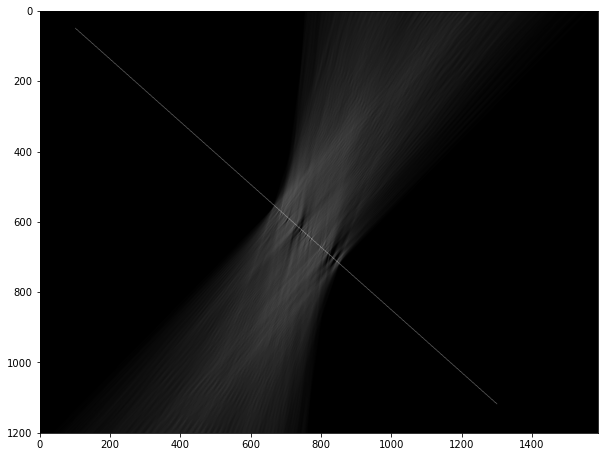

In [32]:
if IM_PATH == '../sample_images/Moscow.jpg':
    hough_v_ = hough_v.copy()

    c0 = 100
    c1 = 1300
    r0 = int(k * c0 + b)
    r1 = int(k * c1 + b)
    rr, cc = draw.line(r0, c0, r1, c1)

    hough_v_[rr, cc] = 2 * np.max(hough_v_)

    render_image(hough_v_, grayscale=True)
else:
    print('This visualisation has been hardcoded for Moscow.jpg.')

#### Visualisation of computed vanishing points

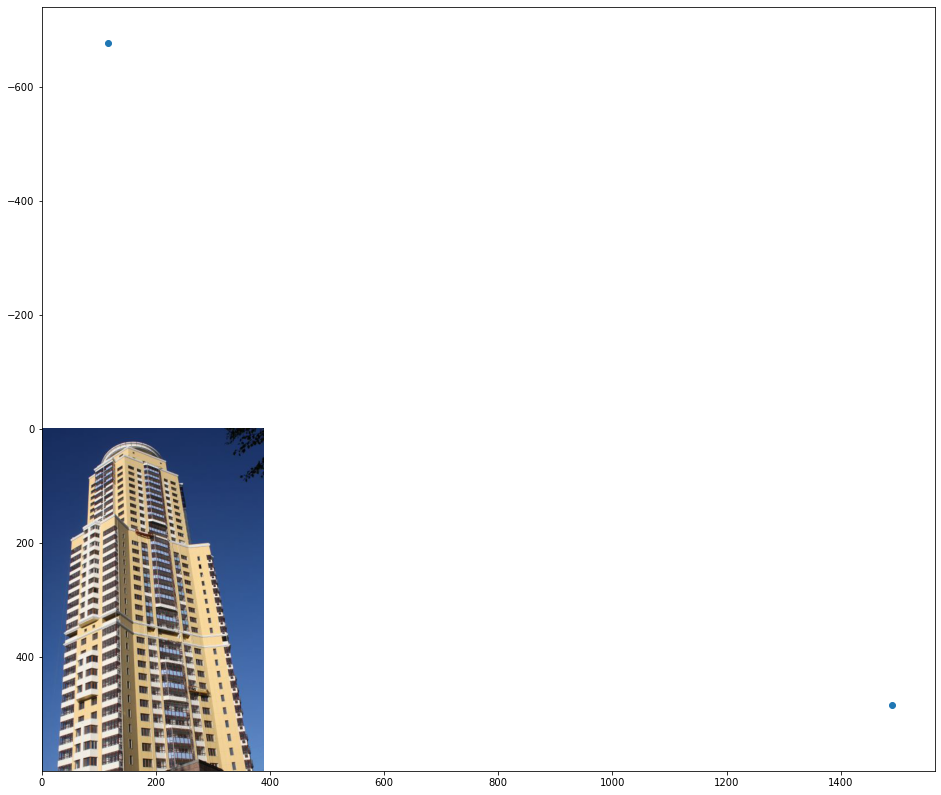

In [33]:
fig = plot.figure(figsize=(16, 16))
plot.imshow(image);
plot.scatter([v_h[1], v_v[1]], [v_h[0], v_v[0]]);